# Casper Neo. MPCS 52010 Computer Architecture.

In [61]:
import os
import subprocess
import re
import matplotlib.pyplot as plt

In [99]:
DEBUG = False
READ_COLOR ='blue'
WRITE_COLOR = 'red'
HIT_LINE_STYLE = '-'
MISS_LINE_STYLE = ':'

In [67]:
def get_stats(flags):
  """Returns the stats from the cache emulator"""
  command = "./target/release/cache_emulator"
  for x in flags:
    # use one or two dashes if its a long or short flag argument
    command += f" -{x}" if len(x) == 1 else f" --{x}"
    command += f" {flags[x]}"
  if DEBUG: print(command)
  raw = subprocess.check_output(command.split(' ')).decode("utf-8")
  results = {}
  for stat in ("read hits", "read misses", "write hits", "write misses"):
    x = re.findall(r"{}\t[0-9]+".format(stat), raw)[0]
    x = x.replace(stat,'')
    results[stat] = int(x)

  return results

In [80]:
def plot_stats(results, xs, ax):

  lines = []
  for stat in ("read hits", "read misses", "write hits", "write misses"):
    c = READ_COLOR if 'read' in stat else WRITE_COLOR
    ls = HIT_LINE_STYLE if 'hits' in stat else MISS_LINE_STYLE
    ys = [r[stat] for r in results]
    if DEBUG: print(f"{stat}: {ys}")
    line, = ax.plot(xs, ys, color=c, linestyle=ls, label=stat)
    lines.append(line)
  return ax

In [54]:
def vary(name, vs, flags={}, xlog=True, ylog=False, ax=None):
  """Varys continuous flag variable `name` over values `vs`.
  Args:
    name: the flag to vary
    vs: the values `name` should take
    flags: other flags to use but not vary
    xlog: log base 2 scale on x axis
    ylog: log base 10 scale on yaxis
  """
  res = []
  for v in vs:
    this_flags = flags.copy()
    this_flags[name] = v
    res.append(get_stats(this_flags))
    
  if not ax:
    fig = plt.figure(figsize=(10,5))
    ax = fig.add_subplot(1, 1, 1)
    ax.set_xlabel(name)
  ax.legend()

  plot_stats(res, vs, ax)
  ax.set_title(f"{flags}" if flags else "")
  if xlog: ax.set_xscale('log', basex=2)
  if ylog: ax.set_yscale('log')

# ANALYSIS

### matrix multiply algorithms performance vs size of the cache.
The CPU is instruted to multiply two (128 * 128) matricies and store the result.

Observe how the block matrix multiply algorithm has far more cache hits than the regular matrix multiply for larger cache sizes. The regular matrix multiply algorithm seems more sensitive to cache size while the block algorithm has consistent performance for cache sizes between 2^13 - 2^18

The dot product really should not be compared to the matrix multiply since it grows linearly in test size as opposed to quadratically. At larger test sizes

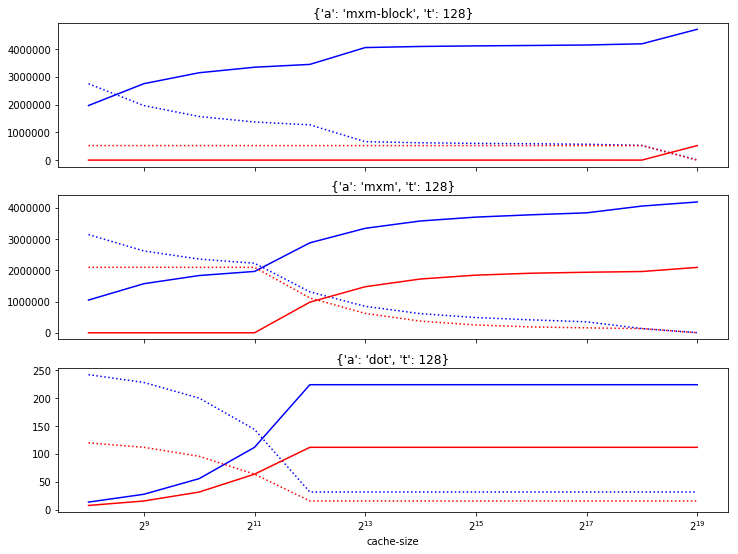

In [88]:
fig, (ax1, ax2, ax3) = plt.subplots(3, sharex=True, figsize=(12,9))
vary("cache-size", [2**x for x in range(8,20)],{"a":"mxm-block","t":128}, ax=ax1)
vary("cache-size", [2**x for x in range(8,20)],{"a":"mxm","t":128}, ax=ax2)
vary("cache-size", [2**x for x in range(8,20)],{"a":"dot","t":128}, ax=ax3)

plt.xlabel("cache-size")
plt.show()

### Replacement Policy vs test size

This test compares the different replacement policies against side length of matricies for the block
matrix algorithm and default values. Observe the write misses are zero for smaller matricies. The line holding the `cij` value is first loaded then held in register as it accumulates `aik * bkj` sums until it is written again. The write misses in the larger test sizes are capacity misses. `LRU` seems to lead to fewer write hits.

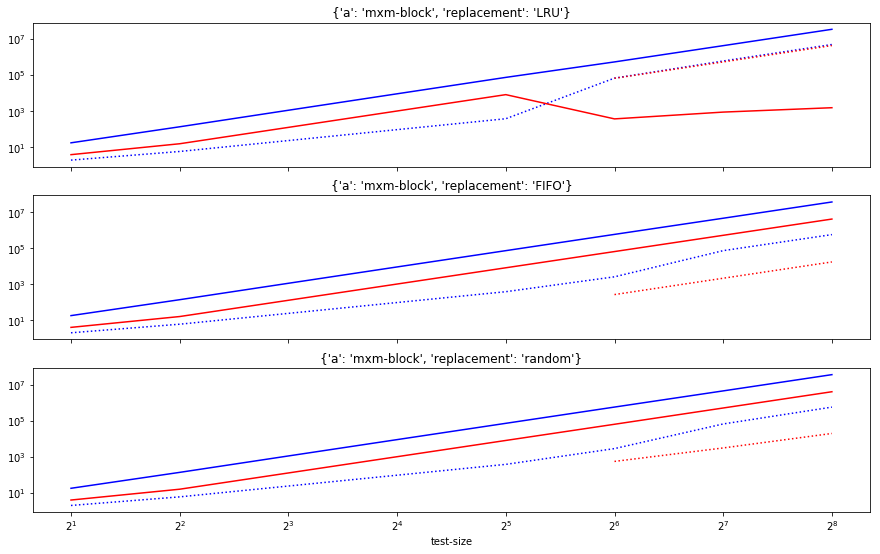

In [86]:
fig, (ax1, ax2, ax3) = plt.subplots(3, sharex=True, figsize=(15,9))
name = "test-size"
xs = [2**x for x in range(1,9)]
vary(name, xs, {"a":"mxm-block","replacement":"LRU"}, ax=ax1, ylog=True)
vary(name, xs, {"a":"mxm-block","replacement":"FIFO"}, ax=ax2, ylog=True)
vary(name, xs, {"a":"mxm-block","replacement":"random"}, ax=ax3, ylog=True)
plt.xlabel(name)
plt.show()

### Associvity vs test-size
Observe in a direct map cache, when the 

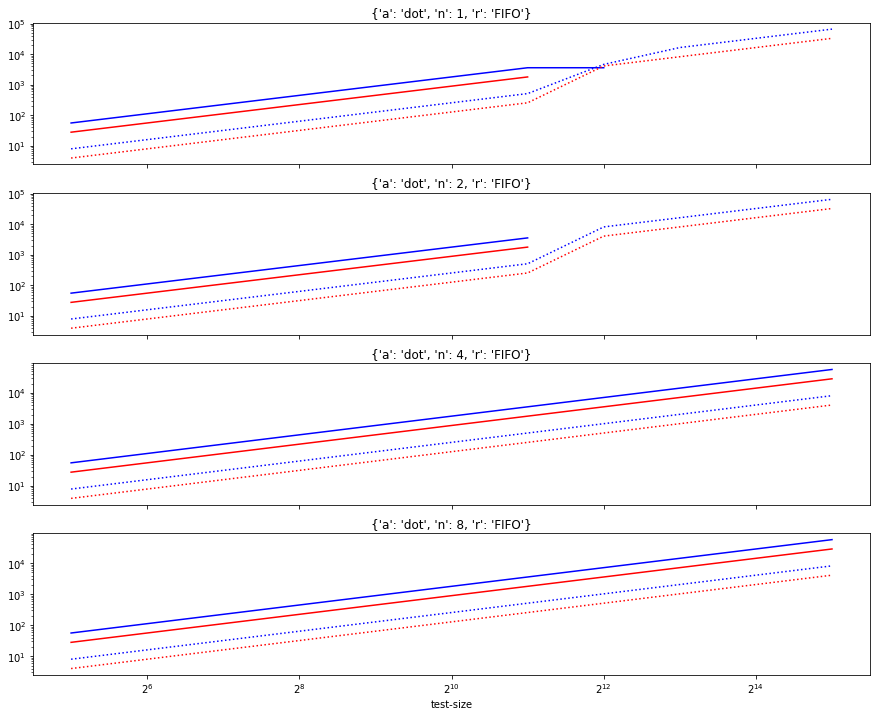

In [100]:
fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, sharex=True, figsize=(15,12))
name = "test-size"
xs = [2**x for x in range(5,16)]
vary(name, xs, {"a":"dot", "n":1, "r":"FIFO"}, ax=ax1, ylog=True)
vary(name, xs, {"a":"dot", "n":2, "r":"FIFO"}, ax=ax2, ylog=True)
vary(name, xs, {"a":"dot", "n":4, "r":"FIFO"}, ax=ax3, ylog=True)
vary(name, xs, {"a":"dot", "n":8, "r":"FIFO"}, ax=ax4, ylog=True)
plt.xlabel(name)
plt.show()

### Block sizes vs test-size